# <center>Detecção de patologias cancerigenas em tomografias pulmonares usando redes neurais</center>

## Configuração do ambiente

Para a execução desse código é necessário ter baixado o jupyter notebook e o Anaconda3, segue os links abaixo:

Jupyter: https://jupyter.org/install

Anaconda: https://www.anaconda.com/products/individual#Downloads

Depois de instalado o anaconda, devemos criar um ambiente rodando os seguintes comandos no Anaconda Console:

```bash
conda create --name TensorFlowEnv python=3.7
conda activate TensorFlowEnv
conda install tensorflow-gpu=2.1 tensorflow=2.1
conda install matplotlib numpy scikit-learn
conda install -c conda-forge pydicom
conda install -c anaconda ipykernel
conda install -c conda-forge opencv
```

Em um console com acesso a python, podendo ser uma nova instancia do anaconda, devemos configurar um kernel para jupyter apontando para o perfil criado no ambiente anaconda. Assim será listado no jupyter o ambiente com as bibliotecas instaladas anteriormente.

```bash
python -m ipykernel install --user --name=TensorFlowEnv
```

## Importando bibliotecas

Para a imlementação do aloritmo é necessário carregar as bibliotecas para manipução de imagens DICOM, leitura de arquivo XML, manipulação de matrizes e computação numérica, framework de aprendizagem de maquina, API de aprendizado profundo, mecanismo de avaliação dos resultados e bibliotecas de apoio a diagnóstico.

In [1]:
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.dom.minidom
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import glob
import random
from scipy.interpolate import interp1d
import cv2

## Checando e configurando Tensorflow GPU

Checando o suporte a uso de GPU no treinamento e ativando a configuração de ajuste de crescimento de memoria da GPU que faz com que a alocação possa ser expandida conforme a necessidade da aplicação for aumentando.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
print('Uso de GPU suportado:', len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Uso de GPU suportado: 1


## Lendo uma imagem DICOM

Exemplo de carga de um arquivo de imagem médica no formato DICOM, leitura dos atributos e visualição da imagem.

Arquivo de anotação: 1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543495374569818432657


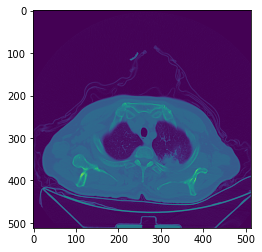

In [3]:
data_raw_img = dicom.read_file('Filtered_Data/Cancer/A0001/1-13.dcm')
annotation_file_name = data_raw_img[0x0008, 0x0018].value
plt.imshow(data_raw_img.pixel_array)
print('Arquivo de anotação:', annotation_file_name)

## Lendo um arquivo de anotação

Exemplo de leitura de um arquivo de anotação. No dataset obtido as anotações são feitas em um arquivo XML.

301 329 351 372


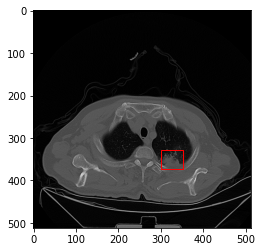

In [4]:
annotation = xml.dom.minidom.parse("Filtered_Data/Annotation/A0001/"+annotation_file_name+".xml");
boundingbox = annotation.getElementsByTagName("bndbox")[0].childNodes
xmin = 0; ymin = 0; xmax = 0; ymax = 0
for coord in boundingbox:
    if coord.nodeType == coord.ELEMENT_NODE:
        if coord.nodeName == 'xmin':
            xmin = int(coord.firstChild.nodeValue)
        if coord.nodeName == 'ymin':
            ymin = int(coord.firstChild.nodeValue)
        if coord.nodeName == 'xmax':
            xmax = int(coord.firstChild.nodeValue)
        if coord.nodeName == 'ymax':
            ymax = int(coord.firstChild.nodeValue)

print(xmin, ymin, xmax, ymax)

fig, ax = plt.subplots()
ax.imshow(data_raw_img.pixel_array, cmap='gray')

rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

## Carregando imagens e anotações em lote

Nesssa etapa iremos carregar as imagens DICOM e as anotações em matrizes que serão usadas pelo tensorFlow no processo de aprendizagem, teste e avaliação.

### Definição de constantes e inicializações

Para configurar a execução da carga em lote iremos definir alguns constantes e iniciar algumas matrizes.

In [5]:
TRAIN_SAMPLES_SIZE = 1000 #3000
TEST_SAMPLES_SIZE = 100 #300
VALIDATION_SAMPLES_SIZE = 100 #300
IMAGE_SIZE = 200

train_labels =  []
train_samples = []
test_labels =  []
test_samples = []
validation_labels =  []
validation_samples = []

### Leitura de anotações

Para facilitar o carregamento em lote dos dados implementaremos uma função que retorna as anotações já normalizadas.

In [8]:
def readAnnotation(path):
    xmin = 0; ymin = 0; xmax = 0; ymax = 0
    annotation = xml.dom.minidom.parse(path);
    boundingbox = annotation.getElementsByTagName("bndbox")[0].childNodes
    rangeAdjust = interp1d([0,(512-1)], [0,1])
    for coord in boundingbox:
        if coord.nodeType == coord.ELEMENT_NODE:
            if coord.nodeName == 'xmin':
                xmin = rangeAdjust(int(coord.firstChild.nodeValue))
            if coord.nodeName == 'ymin':
                ymin = rangeAdjust(int(coord.firstChild.nodeValue))
            if coord.nodeName == 'xmax':
                xmax = rangeAdjust(int(coord.firstChild.nodeValue))
            if coord.nodeName == 'ymax':
                ymax = rangeAdjust(int(coord.firstChild.nodeValue))
    return [1,0,xmin,ymin,xmax,ymax]

### Definição de função de conversão de image

Implementamos uma função para converte o array da imagem DICOM para o formato esperado pelo TensorFlow.

In [7]:
def convImageToTensor(image_array):
    tensor_image = np.array(image_array)
    if tensor_image.shape == (512, 512, 3):
        tensor_image = tensor_image.transpose(2, 0, 1)[0]
        tensor_image = cv2.resize(tensor_image, dsize=(200,200), interpolation=cv2.INTER_CUBIC)
    elif tensor_image.shape == (512, 512):
        tensor_image = cv2.resize(tensor_image, dsize=(200,200), interpolation=cv2.INTER_CUBIC)
    tensor_image = tensor_image.reshape(tensor_image.shape + (1,))
    tensor_image=(tensor_image - np.min(tensor_image))/np.ptp(tensor_image)
    print(tensor_image.shape)
    return tensor_image.tolist()

### Carga em lote dos dados

Para carregar os dados iremos sortear algumas amostras das pastas que contem as images medicas (DICOM) e carregar suas anotações quando apropriado. As listas finais estaram em ordem, sendo todos os dados positivos no inicio e todos os dados negativos no fim.

In [9]:
positive_batch = int((TRAIN_SAMPLES_SIZE + TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE) / 2)
negative_batch = int((TRAIN_SAMPLES_SIZE + TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE) / 2)
for has_cancer_dcm_file_path in random.sample(glob.glob('Filtered_Data'+os.sep+'Cancer'+os.sep+'*'+os.sep+'*.dcm'), positive_batch):
    has_cancer_dcm_file = dicom.read_file(has_cancer_dcm_file_path)
    subject = has_cancer_dcm_file_path.split(os.sep)[-2:-1][0]
    annotation_file_name = has_cancer_dcm_file[0x0008, 0x0018].value + '.xml'
    annotation_full_filename = os.path.join('Filtered_Data', 'Annotation', subject, annotation_file_name)
    total = round(((len(train_samples) + len(test_samples) + len(validation_samples))*100)/(TRAIN_SAMPLES_SIZE + TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE),2)
    print(has_cancer_dcm_file_path, total , '%')
    if len(train_samples) < (TRAIN_SAMPLES_SIZE/2):
        train_samples.append(convImageToTensor(has_cancer_dcm_file.pixel_array))
        train_labels.append(readAnnotation(annotation_full_filename))
    elif len(train_samples) + len(test_samples) < ((TRAIN_SAMPLES_SIZE + TEST_SAMPLES_SIZE)/2):
        test_samples.append(convImageToTensor(has_cancer_dcm_file.pixel_array))
        test_labels.append(readAnnotation(annotation_full_filename))
    else:
        validation_samples.append(convImageToTensor(has_cancer_dcm_file.pixel_array))
        validation_labels.append(readAnnotation(annotation_full_filename))
        
for dont_has_cancer_dcm_file_path in random.sample(glob.glob('Filtered_Data'+os.sep+'Non-Cancer'+os.sep+'*'+os.sep+'*.dcm'), positive_batch):
    dont_has_cancer_dcm_file = dicom.read_file(dont_has_cancer_dcm_file_path)
    total = round(((len(train_samples) + len(test_samples) + len(validation_samples))*100)/(TRAIN_SAMPLES_SIZE + TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE),2)
    print(dont_has_cancer_dcm_file_path, total , '%')
    if len(train_samples) < TRAIN_SAMPLES_SIZE:
        train_samples.append(convImageToTensor(dont_has_cancer_dcm_file.pixel_array))
        train_labels.append([0,1,0,0,0,0])
    elif len(train_samples) + len(test_samples) < (TRAIN_SAMPLES_SIZE + TEST_SAMPLES_SIZE):
        test_samples.append(convImageToTensor(dont_has_cancer_dcm_file.pixel_array))
        test_labels.append([0,1,0,0,0,0])
    else:
        validation_samples.append(convImageToTensor(dont_has_cancer_dcm_file.pixel_array))
        validation_labels.append([0,1,0,0,0,0])
total = round(((len(train_samples) + len(test_samples) + len(validation_samples))*100)/(TRAIN_SAMPLES_SIZE + TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE),2)
print('Done', total , '%')

Filtered_Data\Cancer\A0250\1-099.dcm 0.0 %
(200, 200, 1)
Filtered_Data\Cancer\G0050\1-027.dcm 0.08 %
(200, 200, 1)
Filtered_Data\Cancer\A0189\1-090.dcm 0.17 %
(200, 200, 1)
Filtered_Data\Cancer\A0182\1-185.dcm 0.25 %
(200, 200, 1)
Filtered_Data\Cancer\A0102\1-02.dcm 0.33 %
(200, 200, 1)
Filtered_Data\Cancer\G0055\1-249.dcm 0.42 %
(200, 200, 1)
Filtered_Data\Cancer\A0182\1-208.dcm 0.5 %
(200, 200, 1)
Filtered_Data\Cancer\A0089\1-09.dcm 0.58 %
(200, 200, 1)
Filtered_Data\Cancer\G0003\3-017.dcm 0.67 %
(200, 200, 1)
Filtered_Data\Cancer\G0006\3-019.dcm 0.75 %
(200, 200, 1)
Filtered_Data\Cancer\A0242\1-073.dcm 0.83 %
(200, 200, 1)
Filtered_Data\Cancer\A0232\1-198.dcm 0.92 %
(200, 200, 1)
Filtered_Data\Cancer\A0189\1-086.dcm 1.0 %
(200, 200, 1)
Filtered_Data\Cancer\A0189\1-056.dcm 1.08 %
(200, 200, 1)
Filtered_Data\Cancer\A0229\1-141.dcm 1.17 %
(200, 200, 1)
Filtered_Data\Cancer\A0167\1-146.dcm 1.25 %
(200, 200, 1)
Filtered_Data\Cancer\B0042\1-157.dcm 1.33 %
(200, 200, 1)
Filtered_Data\Cance

Filtered_Data\Cancer\A0169\1-124.dcm 11.83 %
(200, 200, 1)
Filtered_Data\Cancer\G0047\1-165.dcm 11.92 %
(200, 200, 1)
Filtered_Data\Cancer\A0011\3-022.dcm 12.0 %
(200, 200, 1)
Filtered_Data\Cancer\A0200\1-113.dcm 12.08 %
(200, 200, 1)
Filtered_Data\Cancer\A0171\1-204.dcm 12.17 %
(200, 200, 1)
Filtered_Data\Cancer\A0242\1-122.dcm 12.25 %
(200, 200, 1)
Filtered_Data\Cancer\G0011\2-020.dcm 12.33 %
(200, 200, 1)
Filtered_Data\Cancer\B0034\1-122.dcm 12.42 %
(200, 200, 1)
Filtered_Data\Cancer\E0001\2-026.dcm 12.5 %
(200, 200, 1)
Filtered_Data\Cancer\A0198\1-137.dcm 12.58 %
(200, 200, 1)
Filtered_Data\Cancer\G0048\1-070.dcm 12.67 %
(200, 200, 1)
Filtered_Data\Cancer\G0049\1-194.dcm 12.75 %
(200, 200, 1)
Filtered_Data\Cancer\G0033\1-065.dcm 12.83 %
(200, 200, 1)
Filtered_Data\Cancer\G0019\1-42.dcm 12.92 %
(200, 200, 1)
Filtered_Data\Cancer\A0114\3-044.dcm 13.0 %
(200, 200, 1)
Filtered_Data\Cancer\G0028\3-033.dcm 13.08 %
(200, 200, 1)
Filtered_Data\Cancer\A0259\1-185.dcm 13.17 %
(200, 200, 1)
F

Filtered_Data\Cancer\A0261\1-185.dcm 23.58 %
(200, 200, 1)
Filtered_Data\Cancer\A0171\1-225.dcm 23.67 %
(200, 200, 1)
Filtered_Data\Cancer\A0237\1-219.dcm 23.75 %
(200, 200, 1)
Filtered_Data\Cancer\A0026\1-16.dcm 23.83 %
(200, 200, 1)
Filtered_Data\Cancer\A0264\1-120.dcm 23.92 %
(200, 200, 1)
Filtered_Data\Cancer\A0218\1-075.dcm 24.0 %
(200, 200, 1)
Filtered_Data\Cancer\A0229\1-170.dcm 24.08 %
(200, 200, 1)
Filtered_Data\Cancer\A0083\1-163.dcm 24.17 %
(200, 200, 1)
Filtered_Data\Cancer\G0048\1-181.dcm 24.25 %
(200, 200, 1)
Filtered_Data\Cancer\A0198\1-068.dcm 24.33 %
(200, 200, 1)
Filtered_Data\Cancer\A0238\1-081.dcm 24.42 %
(200, 200, 1)
Filtered_Data\Cancer\A0111\1-041.dcm 24.5 %
(200, 200, 1)
Filtered_Data\Cancer\G0021\1-031.dcm 24.58 %
(200, 200, 1)
Filtered_Data\Cancer\G0040\1-152.dcm 24.67 %
(200, 200, 1)
Filtered_Data\Cancer\A0262\1-305.dcm 24.75 %
(200, 200, 1)
Filtered_Data\Cancer\A0188\1-122.dcm 24.83 %
(200, 200, 1)
Filtered_Data\Cancer\A0139\3-020.dcm 24.92 %
(200, 200, 1)


Filtered_Data\Cancer\A0200\1-202.dcm 35.25 %
(200, 200, 1)
Filtered_Data\Cancer\A0185\1-082.dcm 35.33 %
(200, 200, 1)
Filtered_Data\Cancer\A0105\1-09.dcm 35.42 %
(200, 200, 1)
Filtered_Data\Cancer\G0016\2-027.dcm 35.5 %
(200, 200, 1)
Filtered_Data\Cancer\A0222\1-143.dcm 35.58 %
(200, 200, 1)
Filtered_Data\Cancer\A0187\1-078.dcm 35.67 %
(200, 200, 1)
Filtered_Data\Cancer\G0034\1-124.dcm 35.75 %
(200, 200, 1)
Filtered_Data\Cancer\G0034\1-154.dcm 35.83 %
(200, 200, 1)
Filtered_Data\Cancer\A0170\1-060.dcm 35.92 %
(200, 200, 1)
Filtered_Data\Cancer\B0037\1-097.dcm 36.0 %
(200, 200, 1)
Filtered_Data\Cancer\G0040\1-158.dcm 36.08 %
(200, 200, 1)
Filtered_Data\Cancer\G0048\1-098.dcm 36.17 %
(200, 200, 1)
Filtered_Data\Cancer\A0139\1-27.dcm 36.25 %
(200, 200, 1)
Filtered_Data\Cancer\B0038\1-262.dcm 36.33 %
(200, 200, 1)
Filtered_Data\Cancer\A0264\1-073.dcm 36.42 %
(200, 200, 1)
Filtered_Data\Cancer\B0036\1-130.dcm 36.5 %
(200, 200, 1)
Filtered_Data\Cancer\G0047\1-204.dcm 36.58 %
(200, 200, 1)
Fi

Filtered_Data\Cancer\B0042\1-237.dcm 46.92 %
(200, 200, 1)
Filtered_Data\Cancer\A0243\1-126.dcm 47.0 %
(200, 200, 1)
Filtered_Data\Cancer\B0041\1-203.dcm 47.08 %
(200, 200, 1)
Filtered_Data\Cancer\E0003\3-022.dcm 47.17 %
(200, 200, 1)
Filtered_Data\Cancer\B0040\1-120.dcm 47.25 %
(200, 200, 1)
Filtered_Data\Cancer\A0165\1-175.dcm 47.33 %
(200, 200, 1)
Filtered_Data\Cancer\A0242\1-027.dcm 47.42 %
(200, 200, 1)
Filtered_Data\Cancer\G0052\1-189.dcm 47.5 %
(200, 200, 1)
Filtered_Data\Cancer\G0051\1-121.dcm 47.58 %
(200, 200, 1)
Filtered_Data\Cancer\A0183\1-187.dcm 47.67 %
(200, 200, 1)
Filtered_Data\Cancer\G0053\1-123.dcm 47.75 %
(200, 200, 1)
Filtered_Data\Cancer\G0052\1-229.dcm 47.83 %
(200, 200, 1)
Filtered_Data\Cancer\A0249\1-114.dcm 47.92 %
(200, 200, 1)
Filtered_Data\Cancer\G0011\1-23.dcm 48.0 %
(200, 200, 1)
Filtered_Data\Cancer\A0012\1-13.dcm 48.08 %
(200, 200, 1)
Filtered_Data\Cancer\G0033\1-057.dcm 48.17 %
(200, 200, 1)
Filtered_Data\Cancer\A0259\1-216.dcm 48.25 %
(200, 200, 1)
Fi

Filtered_Data\Non-Cancer\B0025\2-009.dcm 58.17 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0053\3-052.dcm 58.25 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0210\3-019.dcm 58.33 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0190\1-166.dcm 58.42 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0150\3-010.dcm 58.5 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0204\5-038.dcm 58.58 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0001\1-01.dcm 58.67 %
(200, 200, 1)
Filtered_Data\Non-Cancer\G0003\1-003.dcm 58.75 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0248\4-016.dcm 58.83 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0206\1-041.dcm 58.92 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0178\4-017.dcm 59.0 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0263\1-166.dcm 59.08 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0113\1-287.dcm 59.17 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0019\3-043.dcm 59.25 %
(200, 200, 1)
Filtered_Data\Non-Cancer\B0033\5-033.dcm 59.33 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0185\1-051.dcm 59.42 %
(200, 200

Filtered_Data\Non-Cancer\A0187\2-030.dcm 69.25 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0166\1-049.dcm 69.33 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0243\3-022.dcm 69.42 %
(200, 200, 1)
Filtered_Data\Non-Cancer\G0053\1-389.dcm 69.5 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0200\3-035.dcm 69.58 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0011\1-053.dcm 69.67 %
(200, 200, 1)
Filtered_Data\Non-Cancer\G0040\1-238.dcm 69.75 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0241\6-085.dcm 69.83 %
(200, 200, 1)
Filtered_Data\Non-Cancer\G0017\1-002.dcm 69.92 %
(200, 200, 1)
Filtered_Data\Non-Cancer\G0056\1-228.dcm 70.0 %
(200, 200, 1)
Filtered_Data\Non-Cancer\B0041\1-432.dcm 70.08 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0204\1-184.dcm 70.17 %
(200, 200, 1)
Filtered_Data\Non-Cancer\B0033\5-012.dcm 70.25 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0182\1-133.dcm 70.33 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0255\1-091.dcm 70.42 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0126\1-07.dcm 70.5 %
(200, 200,

Filtered_Data\Non-Cancer\A0182\1-055.dcm 80.42 %
(200, 200, 1)
Filtered_Data\Non-Cancer\G0034\3-031.dcm 80.5 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0191\3-047.dcm 80.58 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0078\1-089.dcm 80.67 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0169\1-044.dcm 80.75 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0225\1-005.dcm 80.83 %
(200, 200, 1)
Filtered_Data\Non-Cancer\B0033\1-141.dcm 80.92 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0229\1-040.dcm 81.0 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0101\1-07.dcm 81.08 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0240\4-031.dcm 81.17 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0226\5-032.dcm 81.25 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0115\2-014.dcm 81.33 %
(200, 200, 1)
Filtered_Data\Non-Cancer\B0003\2-005.dcm 81.42 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0192\2-036.dcm 81.5 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0225\7-028.dcm 81.58 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0191\1-222.dcm 81.67 %
(200, 200,

Filtered_Data\Non-Cancer\A0214\3-019.dcm 91.58 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0204\1-041.dcm 91.67 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0165\1-653.dcm 91.75 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0211\2-039.dcm 91.83 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0182\3-057.dcm 91.92 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0049\2-008.dcm 92.0 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0228\1-099.dcm 92.08 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0073\1-19.dcm 92.17 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0019\1-022.dcm 92.25 %
(200, 200, 1)
Filtered_Data\Non-Cancer\B0001\3-004.dcm 92.33 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0174\1-342.dcm 92.42 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0214\5-054.dcm 92.5 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0180\1-284.dcm 92.58 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0203\4-041.dcm 92.67 %
(200, 200, 1)
Filtered_Data\Non-Cancer\A0070\3-075.dcm 92.75 %
(200, 200, 1)
Filtered_Data\Non-Cancer\G0054\1-041.dcm 92.83 %
(200, 200

## Embaralhando registros

Os dados foram carregados de forma que os primeiros registros são todos positvos (tem cancer) e os ultimos são todos negativos (não tem cancer) para deixar a distribuição homogenia iremos embaralhar os dados. Nessa parte também vamos converte a matrizes criadas para matrizes do tipo numpy que são suportadas pelo TensorFlow.

In [10]:
train_labels = np.array(train_labels)
train_samples = np.array(train_samples)
train_labels, train_samples = shuffle(train_labels, train_samples)

test_labels = np.array(test_labels)
test_samples = np.array(test_samples)
test_labels, test_samples = shuffle(test_labels, test_samples)

validation_labels = np.array(validation_labels)
validation_samples = np.array(validation_samples)
validation_labels, validation_samples = shuffle(validation_labels, validation_samples)

Verificando se os tamanhos estão corretos

In [11]:
assert len(train_labels) == TRAIN_SAMPLES_SIZE
assert len(train_samples) == TRAIN_SAMPLES_SIZE

assert len(test_labels) == TEST_SAMPLES_SIZE
assert len(test_samples) == TEST_SAMPLES_SIZE

assert len(validation_labels) == VALIDATION_SAMPLES_SIZE
assert len(validation_samples) == VALIDATION_SAMPLES_SIZE

Inspecionando os dados carregados

In [12]:
print(train_samples.shape)
print(train_samples[0].shape)

(1000, 200, 200, 1)
(200, 200, 1)


In [14]:
print(train_labels[0:16])

[[0.         1.         0.         0.         0.         0.        ]
 [1.         0.         0.31898239 0.4148728  0.38943249 0.46966732]
 [1.         0.         0.5890411  0.66731898 0.6888454  0.75733855]
 [1.         0.         0.58317025 0.73581213 0.71037182 0.82191781]
 [1.         0.         0.58121331 0.60665362 0.76712329 0.84540117]
 [1.         0.         0.59491194 0.56947162 0.70450098 0.6888454 ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [1.         0.         0.60469667 0.45205479 0.71232877 0.54990215]
 [1.         0.         0.35029354 0.47553816 0.40704501 0.54598826]
 [1.         0.         0.56360078 0.54794521 0.66927593 0.68101761]
 [0.         1.         0.         0.         0.         0.        ]
 [1.         0.         0.31702544

## Definição do modelo

Para a criação do modelo iremos usar a API Keras para a definição dos tipos de camadas para a criação da nossa rede neural convolucional (CNN).

In [15]:
model = Sequential([
    Conv2D(16, 15, input_shape = (IMAGE_SIZE,IMAGE_SIZE,1)),
    MaxPool2D(pool_size = (4)),
    Conv2D(16, 7),
    Activation('tanh'),
    BatchNormalization(),
    Conv2D(16, 7),
    Activation('tanh'),
    BatchNormalization(),
    Conv2D(16, 7),
    Activation('tanh'),
    BatchNormalization(),
    MaxPool2D(pool_size = (4)),
    Conv2D(16, 3),
    Activation('tanh'),
    BatchNormalization(),
    MaxPool2D(pool_size = (4)),
    Flatten(),
    Dense(16, activation = "tanh"),
    BatchNormalization(),
    Dense(units=6, activation=None)
])

### Sumario da configuração da rede

Para verificar a rede configurada podemos chamar a função sumário.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 186, 186, 16)      3616      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 16)        12560     
_________________________________________________________________
activation (Activation)      (None, 40, 40, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 16)        12560     
_________________________________________________________________
activation_1 (Activation)    (None, 34, 34, 16)        0

### Construção do modelo

O configuração deve ser construida antes de podemos dar inicio ao treino.

In [18]:
model.compile(optimizer=SGD(learning_rate=0.01), loss='mean_squared_error', metrics=['accuracy'])

### Treino da rede

Executando o trei da rede com as imagens de entrada e suas anotações.

In [19]:
model.fit(x=train_samples, y=train_labels, validation_data=(validation_samples,validation_labels), batch_size=32, epochs=3000, verbose=2)

Train on 1000 samples, validate on 100 samples
Epoch 1/3000
1000/1000 - 11s - loss: 0.6426 - accuracy: 0.1810 - val_loss: 0.3399 - val_accuracy: 0.0000e+00
Epoch 2/3000
1000/1000 - 1s - loss: 0.2579 - accuracy: 0.3300 - val_loss: 0.2800 - val_accuracy: 0.0100
Epoch 3/3000
1000/1000 - 1s - loss: 0.2059 - accuracy: 0.4140 - val_loss: 0.2370 - val_accuracy: 0.1200
Epoch 4/3000
1000/1000 - 1s - loss: 0.1727 - accuracy: 0.4900 - val_loss: 0.2036 - val_accuracy: 0.3700
Epoch 5/3000
1000/1000 - 1s - loss: 0.1619 - accuracy: 0.5330 - val_loss: 0.1770 - val_accuracy: 0.5200
Epoch 6/3000
1000/1000 - 1s - loss: 0.1458 - accuracy: 0.5480 - val_loss: 0.1884 - val_accuracy: 0.6000
Epoch 7/3000
1000/1000 - 1s - loss: 0.1340 - accuracy: 0.5980 - val_loss: 0.1451 - val_accuracy: 0.6300
Epoch 8/3000
1000/1000 - 1s - loss: 0.1272 - accuracy: 0.6200 - val_loss: 0.1531 - val_accuracy: 0.6200
Epoch 9/3000
1000/1000 - 1s - loss: 0.1236 - accuracy: 0.6300 - val_loss: 0.1591 - val_accuracy: 0.6100
Epoch 10/300

Epoch 79/3000
1000/1000 - 1s - loss: 0.0642 - accuracy: 0.8750 - val_loss: 0.1227 - val_accuracy: 0.7700
Epoch 80/3000
1000/1000 - 1s - loss: 0.0584 - accuracy: 0.9040 - val_loss: 0.1287 - val_accuracy: 0.7100
Epoch 81/3000
1000/1000 - 1s - loss: 0.0527 - accuracy: 0.9170 - val_loss: 0.1071 - val_accuracy: 0.7400
Epoch 82/3000
1000/1000 - 1s - loss: 0.0535 - accuracy: 0.9070 - val_loss: 0.3076 - val_accuracy: 0.6300
Epoch 83/3000
1000/1000 - 1s - loss: 0.0591 - accuracy: 0.8900 - val_loss: 0.1420 - val_accuracy: 0.6900
Epoch 84/3000
1000/1000 - 1s - loss: 0.0568 - accuracy: 0.9140 - val_loss: 0.1157 - val_accuracy: 0.7100
Epoch 85/3000
1000/1000 - 1s - loss: 0.0550 - accuracy: 0.9210 - val_loss: 0.1444 - val_accuracy: 0.6800
Epoch 86/3000
1000/1000 - 1s - loss: 0.0522 - accuracy: 0.9210 - val_loss: 0.1531 - val_accuracy: 0.7100
Epoch 87/3000
1000/1000 - 1s - loss: 0.0548 - accuracy: 0.9040 - val_loss: 0.1017 - val_accuracy: 0.7700
Epoch 88/3000
1000/1000 - 1s - loss: 0.0544 - accuracy:

Epoch 157/3000
1000/1000 - 1s - loss: 0.0269 - accuracy: 0.9870 - val_loss: 0.0919 - val_accuracy: 0.7800
Epoch 158/3000
1000/1000 - 1s - loss: 0.0230 - accuracy: 0.9890 - val_loss: 0.1120 - val_accuracy: 0.7800
Epoch 159/3000
1000/1000 - 1s - loss: 0.0252 - accuracy: 0.9890 - val_loss: 0.0981 - val_accuracy: 0.7800
Epoch 160/3000
1000/1000 - 1s - loss: 0.0241 - accuracy: 0.9910 - val_loss: 0.1221 - val_accuracy: 0.7500
Epoch 161/3000
1000/1000 - 1s - loss: 0.0241 - accuracy: 0.9880 - val_loss: 0.2041 - val_accuracy: 0.6400
Epoch 162/3000
1000/1000 - 1s - loss: 0.0270 - accuracy: 0.9860 - val_loss: 0.1401 - val_accuracy: 0.7700
Epoch 163/3000
1000/1000 - 1s - loss: 0.0298 - accuracy: 0.9780 - val_loss: 0.0906 - val_accuracy: 0.8200
Epoch 164/3000
1000/1000 - 1s - loss: 0.0212 - accuracy: 0.9940 - val_loss: 0.1066 - val_accuracy: 0.7700
Epoch 165/3000
1000/1000 - 1s - loss: 0.0248 - accuracy: 0.9880 - val_loss: 0.0947 - val_accuracy: 0.7800
Epoch 166/3000
1000/1000 - 1s - loss: 0.0236 -

Epoch 235/3000
1000/1000 - 1s - loss: 0.0216 - accuracy: 0.9860 - val_loss: 0.1022 - val_accuracy: 0.8000
Epoch 236/3000
1000/1000 - 1s - loss: 0.0183 - accuracy: 0.9970 - val_loss: 0.0943 - val_accuracy: 0.8000
Epoch 237/3000
1000/1000 - 1s - loss: 0.0189 - accuracy: 0.9970 - val_loss: 0.0938 - val_accuracy: 0.7800
Epoch 238/3000
1000/1000 - 1s - loss: 0.0160 - accuracy: 0.9990 - val_loss: 0.0868 - val_accuracy: 0.8000
Epoch 239/3000
1000/1000 - 1s - loss: 0.0160 - accuracy: 0.9940 - val_loss: 0.0958 - val_accuracy: 0.8000
Epoch 240/3000
1000/1000 - 1s - loss: 0.0141 - accuracy: 0.9990 - val_loss: 0.1021 - val_accuracy: 0.7900
Epoch 241/3000
1000/1000 - 1s - loss: 0.0162 - accuracy: 0.9960 - val_loss: 0.0963 - val_accuracy: 0.7600
Epoch 242/3000
1000/1000 - 1s - loss: 0.0176 - accuracy: 0.9960 - val_loss: 0.1081 - val_accuracy: 0.8000
Epoch 243/3000
1000/1000 - 1s - loss: 0.0143 - accuracy: 0.9990 - val_loss: 0.0878 - val_accuracy: 0.8100
Epoch 244/3000
1000/1000 - 1s - loss: 0.0172 -

Epoch 313/3000
1000/1000 - 1s - loss: 0.0153 - accuracy: 0.9980 - val_loss: 0.0829 - val_accuracy: 0.8000
Epoch 314/3000
1000/1000 - 1s - loss: 0.0134 - accuracy: 0.9980 - val_loss: 0.1052 - val_accuracy: 0.7300
Epoch 315/3000
1000/1000 - 1s - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0911 - val_accuracy: 0.8400
Epoch 316/3000
1000/1000 - 1s - loss: 0.0146 - accuracy: 0.9970 - val_loss: 0.0825 - val_accuracy: 0.8200
Epoch 317/3000
1000/1000 - 1s - loss: 0.0141 - accuracy: 0.9970 - val_loss: 0.0840 - val_accuracy: 0.8200
Epoch 318/3000
1000/1000 - 1s - loss: 0.0154 - accuracy: 0.9980 - val_loss: 0.0863 - val_accuracy: 0.8100
Epoch 319/3000
1000/1000 - 1s - loss: 0.0117 - accuracy: 0.9980 - val_loss: 0.0974 - val_accuracy: 0.7600
Epoch 320/3000
1000/1000 - 1s - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.8000
Epoch 321/3000
1000/1000 - 1s - loss: 0.0116 - accuracy: 0.9990 - val_loss: 0.0826 - val_accuracy: 0.8000
Epoch 322/3000
1000/1000 - 1s - loss: 0.0115 -

Epoch 391/3000
1000/1000 - 1s - loss: 0.0120 - accuracy: 0.9980 - val_loss: 0.1009 - val_accuracy: 0.8000
Epoch 392/3000
1000/1000 - 1s - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.8300
Epoch 393/3000
1000/1000 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0880 - val_accuracy: 0.7900
Epoch 394/3000
1000/1000 - 1s - loss: 0.0110 - accuracy: 0.9990 - val_loss: 0.0835 - val_accuracy: 0.7800
Epoch 395/3000
1000/1000 - 1s - loss: 0.0126 - accuracy: 0.9990 - val_loss: 0.0825 - val_accuracy: 0.7900
Epoch 396/3000
1000/1000 - 1s - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.0847 - val_accuracy: 0.7900
Epoch 397/3000
1000/1000 - 1s - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0861 - val_accuracy: 0.8100
Epoch 398/3000
1000/1000 - 1s - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0856 - val_accuracy: 0.7900
Epoch 399/3000
1000/1000 - 1s - loss: 0.0136 - accuracy: 0.9980 - val_loss: 0.0843 - val_accuracy: 0.8000
Epoch 400/3000
1000/1000 - 1s - loss: 0.0142 -

Epoch 469/3000
1000/1000 - 1s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0912 - val_accuracy: 0.8000
Epoch 470/3000
1000/1000 - 1s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0854 - val_accuracy: 0.8000
Epoch 471/3000
1000/1000 - 1s - loss: 0.0112 - accuracy: 0.9990 - val_loss: 0.0844 - val_accuracy: 0.8100
Epoch 472/3000
1000/1000 - 1s - loss: 0.0112 - accuracy: 0.9990 - val_loss: 0.0857 - val_accuracy: 0.8000
Epoch 473/3000
1000/1000 - 1s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0883 - val_accuracy: 0.7900
Epoch 474/3000
1000/1000 - 1s - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.0900 - val_accuracy: 0.8000
Epoch 475/3000
1000/1000 - 1s - loss: 0.0104 - accuracy: 0.9990 - val_loss: 0.0851 - val_accuracy: 0.8200
Epoch 476/3000
1000/1000 - 1s - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0834 - val_accuracy: 0.7900
Epoch 477/3000
1000/1000 - 1s - loss: 0.0112 - accuracy: 0.9990 - val_loss: 0.0970 - val_accuracy: 0.7700
Epoch 478/3000
1000/1000 - 1s - loss: 0.0109 -

Epoch 547/3000
1000/1000 - 1s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0829 - val_accuracy: 0.7900
Epoch 548/3000
1000/1000 - 1s - loss: 0.0105 - accuracy: 0.9980 - val_loss: 0.1160 - val_accuracy: 0.7300
Epoch 549/3000
1000/1000 - 1s - loss: 0.0140 - accuracy: 0.9990 - val_loss: 0.0832 - val_accuracy: 0.7800
Epoch 550/3000
1000/1000 - 1s - loss: 0.0125 - accuracy: 0.9950 - val_loss: 0.0825 - val_accuracy: 0.8100
Epoch 551/3000
1000/1000 - 1s - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0872 - val_accuracy: 0.8200
Epoch 552/3000
1000/1000 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0827 - val_accuracy: 0.7800
Epoch 553/3000
1000/1000 - 1s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.7700
Epoch 554/3000
1000/1000 - 1s - loss: 0.0113 - accuracy: 0.9990 - val_loss: 0.0834 - val_accuracy: 0.7900
Epoch 555/3000
1000/1000 - 1s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 0.7800
Epoch 556/3000
1000/1000 - 1s - loss: 0.0097 -

Epoch 625/3000
1000/1000 - 1s - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0820 - val_accuracy: 0.7700
Epoch 626/3000
1000/1000 - 1s - loss: 0.0088 - accuracy: 0.9990 - val_loss: 0.0787 - val_accuracy: 0.8200
Epoch 627/3000
1000/1000 - 1s - loss: 0.0116 - accuracy: 0.9960 - val_loss: 0.1533 - val_accuracy: 0.7000
Epoch 628/3000
1000/1000 - 1s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0813 - val_accuracy: 0.7700
Epoch 629/3000
1000/1000 - 1s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.7800
Epoch 630/3000
1000/1000 - 1s - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.0807 - val_accuracy: 0.8100
Epoch 631/3000
1000/1000 - 1s - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.0800 - val_accuracy: 0.8400
Epoch 632/3000
1000/1000 - 1s - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0893 - val_accuracy: 0.7900
Epoch 633/3000
1000/1000 - 1s - loss: 0.0078 - accuracy: 0.9990 - val_loss: 0.0877 - val_accuracy: 0.7700
Epoch 634/3000
1000/1000 - 1s - loss: 0.0095 -

Epoch 703/3000
1000/1000 - 1s - loss: 0.0088 - accuracy: 0.9990 - val_loss: 0.0858 - val_accuracy: 0.8000
Epoch 704/3000
1000/1000 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.8300
Epoch 705/3000
1000/1000 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0806 - val_accuracy: 0.8100
Epoch 706/3000
1000/1000 - 1s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0789 - val_accuracy: 0.8000
Epoch 707/3000
1000/1000 - 1s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0793 - val_accuracy: 0.8200
Epoch 708/3000
1000/1000 - 1s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0878 - val_accuracy: 0.7900
Epoch 709/3000
1000/1000 - 1s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0951 - val_accuracy: 0.7900
Epoch 710/3000
1000/1000 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 0.8300
Epoch 711/3000
1000/1000 - 1s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0820 - val_accuracy: 0.8300
Epoch 712/3000
1000/1000 - 1s - loss: 0.0074 -

Epoch 781/3000
1000/1000 - 1s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 0.8200
Epoch 782/3000
1000/1000 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0777 - val_accuracy: 0.8300
Epoch 783/3000
1000/1000 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0816 - val_accuracy: 0.8200
Epoch 784/3000
1000/1000 - 1s - loss: 0.0085 - accuracy: 0.9990 - val_loss: 0.0816 - val_accuracy: 0.7900
Epoch 785/3000
1000/1000 - 1s - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1116 - val_accuracy: 0.7000
Epoch 786/3000
1000/1000 - 1s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0806 - val_accuracy: 0.7900
Epoch 787/3000
1000/1000 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0792 - val_accuracy: 0.8000
Epoch 788/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0912 - val_accuracy: 0.7800
Epoch 789/3000
1000/1000 - 1s - loss: 0.0083 - accuracy: 0.9990 - val_loss: 0.0773 - val_accuracy: 0.8000
Epoch 790/3000
1000/1000 - 1s - loss: 0.0099 -

Epoch 859/3000
1000/1000 - 1s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0769 - val_accuracy: 0.7800
Epoch 860/3000
1000/1000 - 1s - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0831 - val_accuracy: 0.7900
Epoch 861/3000
1000/1000 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 0.8100
Epoch 862/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.8300
Epoch 863/3000
1000/1000 - 1s - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0841 - val_accuracy: 0.8200
Epoch 864/3000
1000/1000 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0790 - val_accuracy: 0.8100
Epoch 865/3000
1000/1000 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.8200
Epoch 866/3000
1000/1000 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0781 - val_accuracy: 0.8400
Epoch 867/3000
1000/1000 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.8400
Epoch 868/3000
1000/1000 - 1s - loss: 0.0073 -

Epoch 937/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.8000
Epoch 938/3000
1000/1000 - 1s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0781 - val_accuracy: 0.8000
Epoch 939/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.7900
Epoch 940/3000
1000/1000 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 0.8200
Epoch 941/3000
1000/1000 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.8200
Epoch 942/3000
1000/1000 - 1s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 0.8400
Epoch 943/3000
1000/1000 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 0.8100
Epoch 944/3000
1000/1000 - 1s - loss: 0.0078 - accuracy: 0.9990 - val_loss: 0.0809 - val_accuracy: 0.7900
Epoch 945/3000
1000/1000 - 1s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0836 - val_accuracy: 0.8300
Epoch 946/3000
1000/1000 - 1s - loss: 0.0094 -

Epoch 1015/3000
1000/1000 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0849 - val_accuracy: 0.8300
Epoch 1016/3000
1000/1000 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.7700
Epoch 1017/3000
1000/1000 - 1s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.7900
Epoch 1018/3000
1000/1000 - 1s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0787 - val_accuracy: 0.8300
Epoch 1019/3000
1000/1000 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0787 - val_accuracy: 0.8200
Epoch 1020/3000
1000/1000 - 1s - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0901 - val_accuracy: 0.8000
Epoch 1021/3000
1000/1000 - 1s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0831 - val_accuracy: 0.8000
Epoch 1022/3000
1000/1000 - 1s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0776 - val_accuracy: 0.8000
Epoch 1023/3000
1000/1000 - 1s - loss: 0.0090 - accuracy: 0.9990 - val_loss: 0.0788 - val_accuracy: 0.8200
Epoch 1024/3000
1000/1000 - 1s - loss

Epoch 1092/3000
1000/1000 - 1s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.7800
Epoch 1093/3000
1000/1000 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.8300
Epoch 1094/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0833 - val_accuracy: 0.8000
Epoch 1095/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.7900
Epoch 1096/3000
1000/1000 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0882 - val_accuracy: 0.8000
Epoch 1097/3000
1000/1000 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.8300
Epoch 1098/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.8200
Epoch 1099/3000
1000/1000 - 1s - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 0.8000
Epoch 1100/3000
1000/1000 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 0.8400
Epoch 1101/3000
1000/1000 - 1s - loss

Epoch 1169/3000
1000/1000 - 1s - loss: 0.0077 - accuracy: 0.9990 - val_loss: 0.0802 - val_accuracy: 0.8300
Epoch 1170/3000
1000/1000 - 1s - loss: 0.0076 - accuracy: 0.9990 - val_loss: 0.1010 - val_accuracy: 0.8200
Epoch 1171/3000
1000/1000 - 1s - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0871 - val_accuracy: 0.7700
Epoch 1172/3000
1000/1000 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.8400
Epoch 1173/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.8200
Epoch 1174/3000
1000/1000 - 1s - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.0837 - val_accuracy: 0.8000
Epoch 1175/3000
1000/1000 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.8300
Epoch 1176/3000
1000/1000 - 1s - loss: 0.0095 - accuracy: 0.9990 - val_loss: 0.0771 - val_accuracy: 0.8200
Epoch 1177/3000
1000/1000 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0789 - val_accuracy: 0.8000
Epoch 1178/3000
1000/1000 - 1s - loss

Epoch 1246/3000
1000/1000 - 1s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.8300
Epoch 1247/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0743 - val_accuracy: 0.8000
Epoch 1248/3000
1000/1000 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.8300
Epoch 1249/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0739 - val_accuracy: 0.8400
Epoch 1250/3000
1000/1000 - 1s - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.0749 - val_accuracy: 0.8200
Epoch 1251/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0733 - val_accuracy: 0.8400
Epoch 1252/3000
1000/1000 - 1s - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0877 - val_accuracy: 0.7900
Epoch 1253/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 0.8300
Epoch 1254/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0737 - val_accuracy: 0.8300
Epoch 1255/3000
1000/1000 - 1s - loss

Epoch 1323/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.8000
Epoch 1324/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0828 - val_accuracy: 0.8100
Epoch 1325/3000
1000/1000 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.8100
Epoch 1326/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 0.8200
Epoch 1327/3000
1000/1000 - 1s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0777 - val_accuracy: 0.8200
Epoch 1328/3000
1000/1000 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.8500
Epoch 1329/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.8300
Epoch 1330/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0822 - val_accuracy: 0.7900
Epoch 1331/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.8300
Epoch 1332/3000
1000/1000 - 1s - loss

Epoch 1400/3000
1000/1000 - 1s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.8200
Epoch 1401/3000
1000/1000 - 1s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 0.8200
Epoch 1402/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0787 - val_accuracy: 0.8400
Epoch 1403/3000
1000/1000 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 0.8100
Epoch 1404/3000
1000/1000 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0809 - val_accuracy: 0.8000
Epoch 1405/3000
1000/1000 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.8500
Epoch 1406/3000
1000/1000 - 1s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0798 - val_accuracy: 0.8100
Epoch 1407/3000
1000/1000 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.8200
Epoch 1408/3000
1000/1000 - 1s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0749 - val_accuracy: 0.8100
Epoch 1409/3000
1000/1000 - 1s - loss

Epoch 1477/3000
1000/1000 - 1s - loss: 0.0068 - accuracy: 0.9990 - val_loss: 0.0801 - val_accuracy: 0.7900
Epoch 1478/3000
1000/1000 - 1s - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0838 - val_accuracy: 0.8100
Epoch 1479/3000
1000/1000 - 1s - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.0771 - val_accuracy: 0.8400
Epoch 1480/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.8200
Epoch 1481/3000
1000/1000 - 1s - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.0805 - val_accuracy: 0.8100
Epoch 1482/3000
1000/1000 - 1s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 0.8300
Epoch 1483/3000
1000/1000 - 1s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0792 - val_accuracy: 0.8300
Epoch 1484/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.8100
Epoch 1485/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.8200
Epoch 1486/3000
1000/1000 - 1s - loss

Epoch 1554/3000
1000/1000 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0761 - val_accuracy: 0.8400
Epoch 1555/3000
1000/1000 - 1s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0730 - val_accuracy: 0.8300
Epoch 1556/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0722 - val_accuracy: 0.8400
Epoch 1557/3000
1000/1000 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 0.8400
Epoch 1558/3000
1000/1000 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.8200
Epoch 1559/3000
1000/1000 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.8300
Epoch 1560/3000
1000/1000 - 1s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0745 - val_accuracy: 0.8200
Epoch 1561/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0737 - val_accuracy: 0.8200
Epoch 1562/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0735 - val_accuracy: 0.8400
Epoch 1563/3000
1000/1000 - 1s - loss

Epoch 1631/3000
1000/1000 - 1s - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 0.8100
Epoch 1632/3000
1000/1000 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0944 - val_accuracy: 0.7700
Epoch 1633/3000
1000/1000 - 1s - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0744 - val_accuracy: 0.8500
Epoch 1634/3000
1000/1000 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.8500
Epoch 1635/3000
1000/1000 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0813 - val_accuracy: 0.8100
Epoch 1636/3000
1000/1000 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0735 - val_accuracy: 0.8300
Epoch 1637/3000
1000/1000 - 1s - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0779 - val_accuracy: 0.8200
Epoch 1638/3000
1000/1000 - 1s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.8200
Epoch 1639/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.0754 - val_accuracy: 0.8400
Epoch 1640/3000
1000/1000 - 1s - loss

Epoch 1708/3000
1000/1000 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.8000
Epoch 1709/3000
1000/1000 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 0.8500
Epoch 1710/3000
1000/1000 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.8100
Epoch 1711/3000
1000/1000 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 0.8200
Epoch 1712/3000
1000/1000 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0756 - val_accuracy: 0.8300
Epoch 1713/3000
1000/1000 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0806 - val_accuracy: 0.8200
Epoch 1714/3000
1000/1000 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0761 - val_accuracy: 0.8200
Epoch 1715/3000
1000/1000 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.8100
Epoch 1716/3000
1000/1000 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 0.8200
Epoch 1717/3000
1000/1000 - 1s - loss

Epoch 1785/3000
1000/1000 - 1s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0752 - val_accuracy: 0.8300
Epoch 1786/3000
1000/1000 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0741 - val_accuracy: 0.8300
Epoch 1787/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.8000
Epoch 1788/3000
1000/1000 - 1s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.8100
Epoch 1789/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.8000
Epoch 1790/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0728 - val_accuracy: 0.8200
Epoch 1791/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 0.8400
Epoch 1792/3000
1000/1000 - 1s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.8200
Epoch 1793/3000
1000/1000 - 1s - loss: 0.0071 - accuracy: 0.9990 - val_loss: 0.0727 - val_accuracy: 0.8400
Epoch 1794/3000
1000/1000 - 1s - loss

Epoch 1862/3000
1000/1000 - 1s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.8200
Epoch 1863/3000
1000/1000 - 1s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.7800
Epoch 1864/3000
1000/1000 - 1s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0800 - val_accuracy: 0.7900
Epoch 1865/3000
1000/1000 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0767 - val_accuracy: 0.8200
Epoch 1866/3000
1000/1000 - 1s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.8500
Epoch 1867/3000
1000/1000 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 0.8200
Epoch 1868/3000
1000/1000 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.8300
Epoch 1869/3000
1000/1000 - 1s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.8300
Epoch 1870/3000
1000/1000 - 1s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.8400
Epoch 1871/3000
1000/1000 - 1s - loss

Epoch 1939/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0709 - val_accuracy: 0.8100
Epoch 1940/3000
1000/1000 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0750 - val_accuracy: 0.8300
Epoch 1941/3000
1000/1000 - 1s - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0788 - val_accuracy: 0.8100
Epoch 1942/3000
1000/1000 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0743 - val_accuracy: 0.8200
Epoch 1943/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.0772 - val_accuracy: 0.8100
Epoch 1944/3000
1000/1000 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 0.8200
Epoch 1945/3000
1000/1000 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0764 - val_accuracy: 0.8300
Epoch 1946/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0752 - val_accuracy: 0.8300
Epoch 1947/3000
1000/1000 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.8300
Epoch 1948/3000
1000/1000 - 1s - loss

Epoch 2016/3000
1000/1000 - 1s - loss: 0.0090 - accuracy: 0.9950 - val_loss: 0.1240 - val_accuracy: 0.7000
Epoch 2017/3000
1000/1000 - 1s - loss: 0.0080 - accuracy: 0.9960 - val_loss: 0.0773 - val_accuracy: 0.8300
Epoch 2018/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 0.8200
Epoch 2019/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0776 - val_accuracy: 0.8500
Epoch 2020/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0749 - val_accuracy: 0.8300
Epoch 2021/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.0767 - val_accuracy: 0.8200
Epoch 2022/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0750 - val_accuracy: 0.8300
Epoch 2023/3000
1000/1000 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.8100
Epoch 2024/3000
1000/1000 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 0.8100
Epoch 2025/3000
1000/1000 - 1s - loss

Epoch 2093/3000
1000/1000 - 1s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.7900
Epoch 2094/3000
1000/1000 - 1s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 0.8100
Epoch 2095/3000
1000/1000 - 1s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.8400
Epoch 2096/3000
1000/1000 - 1s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 0.8300
Epoch 2097/3000
1000/1000 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0858 - val_accuracy: 0.7900
Epoch 2098/3000
1000/1000 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0762 - val_accuracy: 0.8200
Epoch 2099/3000
1000/1000 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0789 - val_accuracy: 0.8200
Epoch 2100/3000
1000/1000 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 0.8300
Epoch 2101/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0750 - val_accuracy: 0.8200
Epoch 2102/3000
1000/1000 - 1s - loss

Epoch 2170/3000
1000/1000 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.8200
Epoch 2171/3000
1000/1000 - 1s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.8200
Epoch 2172/3000
1000/1000 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.8400
Epoch 2173/3000
1000/1000 - 1s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0786 - val_accuracy: 0.8300
Epoch 2174/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0813 - val_accuracy: 0.8100
Epoch 2175/3000
1000/1000 - 1s - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0794 - val_accuracy: 0.8100
Epoch 2176/3000
1000/1000 - 1s - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0773 - val_accuracy: 0.8100
Epoch 2177/3000
1000/1000 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0827 - val_accuracy: 0.7600
Epoch 2178/3000
1000/1000 - 1s - loss: 0.0083 - accuracy: 0.9990 - val_loss: 0.0787 - val_accuracy: 0.8100
Epoch 2179/3000
1000/1000 - 1s - loss

Epoch 2247/3000
1000/1000 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 0.8200
Epoch 2248/3000
1000/1000 - 1s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.8200
Epoch 2249/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.8300
Epoch 2250/3000
1000/1000 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 0.7900
Epoch 2251/3000
1000/1000 - 1s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.8100
Epoch 2252/3000
1000/1000 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 0.8300
Epoch 2253/3000
1000/1000 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.8300
Epoch 2254/3000
1000/1000 - 1s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0760 - val_accuracy: 0.8200
Epoch 2255/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.7900
Epoch 2256/3000
1000/1000 - 1s - loss

Epoch 2324/3000
1000/1000 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.8300
Epoch 2325/3000
1000/1000 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0790 - val_accuracy: 0.8300
Epoch 2326/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0750 - val_accuracy: 0.8400
Epoch 2327/3000
1000/1000 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 0.8300
Epoch 2328/3000
1000/1000 - 1s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.8000
Epoch 2329/3000
1000/1000 - 1s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0752 - val_accuracy: 0.8100
Epoch 2330/3000
1000/1000 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 0.8100
Epoch 2331/3000
1000/1000 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0752 - val_accuracy: 0.8300
Epoch 2332/3000
1000/1000 - 1s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0757 - val_accuracy: 0.8100
Epoch 2333/3000
1000/1000 - 1s - loss

Epoch 2401/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0768 - val_accuracy: 0.8100
Epoch 2402/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0800 - val_accuracy: 0.8200
Epoch 2403/3000
1000/1000 - 1s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.8100
Epoch 2404/3000
1000/1000 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.8100
Epoch 2405/3000
1000/1000 - 1s - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.1193 - val_accuracy: 0.7500
Epoch 2406/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.8200
Epoch 2407/3000
1000/1000 - 1s - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0810 - val_accuracy: 0.8100
Epoch 2408/3000
1000/1000 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.8300
Epoch 2409/3000
1000/1000 - 1s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0786 - val_accuracy: 0.7900
Epoch 2410/3000
1000/1000 - 1s - loss

Epoch 2478/3000
1000/1000 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0786 - val_accuracy: 0.8400
Epoch 2479/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 0.8300
Epoch 2480/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0768 - val_accuracy: 0.8200
Epoch 2481/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.0761 - val_accuracy: 0.8200
Epoch 2482/3000
1000/1000 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.8300
Epoch 2483/3000
1000/1000 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0757 - val_accuracy: 0.8100
Epoch 2484/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.8200
Epoch 2485/3000
1000/1000 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0761 - val_accuracy: 0.8100
Epoch 2486/3000
1000/1000 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.8200
Epoch 2487/3000
1000/1000 - 1s - loss

Epoch 2555/3000
1000/1000 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0734 - val_accuracy: 0.8400
Epoch 2556/3000
1000/1000 - 1s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0753 - val_accuracy: 0.8200
Epoch 2557/3000
1000/1000 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0743 - val_accuracy: 0.8300
Epoch 2558/3000
1000/1000 - 1s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0756 - val_accuracy: 0.8000
Epoch 2559/3000
1000/1000 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0746 - val_accuracy: 0.8200
Epoch 2560/3000
1000/1000 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.8200
Epoch 2561/3000
1000/1000 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0760 - val_accuracy: 0.8200
Epoch 2562/3000
1000/1000 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.8200
Epoch 2563/3000
1000/1000 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0756 - val_accuracy: 0.8300
Epoch 2564/3000
1000/1000 - 1s - loss

Epoch 2632/3000
1000/1000 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0784 - val_accuracy: 0.7700
Epoch 2633/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 0.8000
Epoch 2634/3000
1000/1000 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.8300
Epoch 2635/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.0776 - val_accuracy: 0.8100
Epoch 2636/3000
1000/1000 - 1s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0745 - val_accuracy: 0.8300
Epoch 2637/3000
1000/1000 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0836 - val_accuracy: 0.7800
Epoch 2638/3000
1000/1000 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.8100
Epoch 2639/3000
1000/1000 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.8100
Epoch 2640/3000
1000/1000 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0752 - val_accuracy: 0.8200
Epoch 2641/3000
1000/1000 - 1s - loss

Epoch 2709/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0822 - val_accuracy: 0.8000
Epoch 2710/3000
1000/1000 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0760 - val_accuracy: 0.8200
Epoch 2711/3000
1000/1000 - 1s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.8100
Epoch 2712/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0782 - val_accuracy: 0.8100
Epoch 2713/3000
1000/1000 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0762 - val_accuracy: 0.8500
Epoch 2714/3000
1000/1000 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.1022 - val_accuracy: 0.7100
Epoch 2715/3000
1000/1000 - 1s - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0775 - val_accuracy: 0.8300
Epoch 2716/3000
1000/1000 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0769 - val_accuracy: 0.8100
Epoch 2717/3000
1000/1000 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0769 - val_accuracy: 0.8100
Epoch 2718/3000
1000/1000 - 1s - loss

Epoch 2786/3000
1000/1000 - 1s - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0849 - val_accuracy: 0.7800
Epoch 2787/3000
1000/1000 - 1s - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.0785 - val_accuracy: 0.8100
Epoch 2788/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0757 - val_accuracy: 0.8100
Epoch 2789/3000
1000/1000 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.8000
Epoch 2790/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.8100
Epoch 2791/3000
1000/1000 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.8200
Epoch 2792/3000
1000/1000 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 0.8200
Epoch 2793/3000
1000/1000 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.8200
Epoch 2794/3000
1000/1000 - 1s - loss: 0.0070 - accuracy: 0.9990 - val_loss: 0.0747 - val_accuracy: 0.8400
Epoch 2795/3000
1000/1000 - 1s - loss

Epoch 2863/3000
1000/1000 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.8100
Epoch 2864/3000
1000/1000 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.8100
Epoch 2865/3000
1000/1000 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.8100
Epoch 2866/3000
1000/1000 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0812 - val_accuracy: 0.7700
Epoch 2867/3000
1000/1000 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.8200
Epoch 2868/3000
1000/1000 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0760 - val_accuracy: 0.8000
Epoch 2869/3000
1000/1000 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.8200
Epoch 2870/3000
1000/1000 - 1s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.8100
Epoch 2871/3000
1000/1000 - 1s - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0773 - val_accuracy: 0.8200
Epoch 2872/3000
1000/1000 - 1s - loss

Epoch 2940/3000
1000/1000 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 0.8100
Epoch 2941/3000
1000/1000 - 1s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.8100
Epoch 2942/3000
1000/1000 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.8100
Epoch 2943/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.8300
Epoch 2944/3000
1000/1000 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0924 - val_accuracy: 0.8000
Epoch 2945/3000
1000/1000 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 0.8300
Epoch 2946/3000
1000/1000 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.7900
Epoch 2947/3000
1000/1000 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0778 - val_accuracy: 0.8200
Epoch 2948/3000
1000/1000 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.8500
Epoch 2949/3000
1000/1000 - 1s - loss

### Avaliação dos resultados

Rodando um teste para avaliar os resultados.

In [20]:
print("Resultados nas images de teste")
results = model.evaluate(test_samples, test_labels)
print("test loss, test acc:", results)

Resultados nas images de teste
100/100 [==============================] - 0s 601us/sample - loss: 0.0895 - accuracy: 0.7900
test loss, test acc: [0.08953256323933602, 0.79]


In [41]:
print(test_labels[4])

[1.         0.         0.5890411  0.53033268 0.67318982 0.64970646]


[ 1.0128809  -0.02309138  0.544592    0.529809    0.63135993  0.6243594 ]
153.6869062781334 152.21599531173706 162.32031351327896 161.6237631738186
158.1095890410959 152.26810176125244 166.48238747553816 164.1457925636008


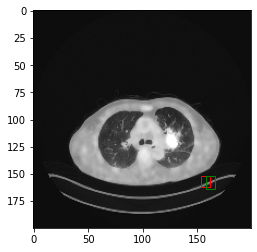

In [42]:
predictions = model.predict(x=test_samples, verbose=0)

iterator=4

print(predictions[iterator])
prediction = predictions[iterator]

rangeAdjust = interp1d([-1,1],[0,(200-1)])
xmin = rangeAdjust(prediction[2])
ymin = rangeAdjust(prediction[3])
xmax = rangeAdjust(prediction[4])
ymax = rangeAdjust(prediction[5])

xmin_real = rangeAdjust(test_labels[iterator][2])
ymin_real = rangeAdjust(test_labels[iterator][3])
xmax_real = rangeAdjust(test_labels[iterator][4])
ymax_real = rangeAdjust(test_labels[iterator][5])

print(xmin,ymin,xmax,ymax)
print(xmin_real,ymin_real,xmax_real,ymax_real)

fig, ax = plt.subplots()
ax.imshow(test_samples[iterator], cmap='gray')

rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

rect2 = patches.Rectangle((xmin_real, ymin_real), xmax_real-xmin_real, ymax_real-ymin_real, linewidth=1, edgecolor='g') , facecolor='none')
ax.add_patch(rect2)
plt.show()

In [24]:
arquivo_treino = 'Filtered_Data/trainCNNFinal.h5'

In [25]:
if os.path.isfile(arquivo_treino) is False:
    print('Salvando arquivo de treino...')
    model.save(arquivo_treino)
else:
    print('Ignorando o salvamento. Para salvar exclua o arquivo existente ou use outro nome.')

Salvando arquivo de treino...


In [26]:
if os.path.isfile(arquivo_treino) is True:
    print('Carregando arquivo de treino...')
    model = load_model(arquivo_treino)

Carregando arquivo de treino...


In [ ]:
import gc
gc.collect()